### Homework Assignment 2 

Name: Zenas Huang

Instructions:

Implement the K-means algorithm AND the Expectation Maximization algorithm for clustering using a Gaussian Mixture Model (GMM). Run your algorithms on the data file "clusters.txt" using K, the number of clusters, set to 3. Report the centroid of each cluster in K-means; and report the mean, amplitude and covariance matrix of each Gaussian in GMM. Compare the results of the two algorithms. The data file contains 150 2D points. Each row in the file contains the coordinates of a single point.

In [1]:
#Import basic packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal as mvn

In [2]:
#Read in Data
data = pd.read_csv('./clusters.txt',header = None)
data.columns = ['x','y']
#verify data was read in correctly
print('There are', len(data), 'data points.')
data.head()


There are 150 data points.


,x,y
0,-1.861331,-2.991683
1,-2.170092,-3.292318
2,-1.014081,0.385795
3,-2.912943,-2.579539
4,0.035721,-0.799698


#### K-means Clustering Implementation

In [3]:
#K-means Clustering Functions
np.random.seed(0)
def initialize_centroids(data, k):
    #randomly select k points from the data
    num_rows = data.shape[0]
    random_indices = np.random.choice(num_rows,size=k)
    #add white noise to the selected points
    noise = np.random.normal(size=(k,2))
    centroids = data[random_indices,:] + noise
    return centroids

def nearest_centroid(data, centroids):
    #store the distance to the closest centroid for each point in an array
    euclidean_distances = np.sqrt(((data - centroids[:,np.newaxis])**2).sum(axis=2))    
    #return an array of centroid indices (0,1,2 in the case of k = 3) for each point in the dataset   
    return np.argmin(euclidean_distances,axis=0)

def update_centroids(data, nearest, centroids):
    #returns the new centroids assigned based on the points closest
    cent = []
    for i in range(len(centroids)):
        cent.append(data[nearest==i].mean(axis=0))
        new_centroids = np.array(cent)
    return new_centroids

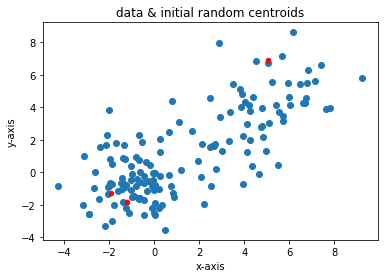

In [4]:
#initialize a few random centroids to begin
np.random.seed(0)
k = 3
datapoints = np.asarray(data)
centroids = initialize_centroids(datapoints,k)
plt.scatter(datapoints[:,0],datapoints[:,1])
plt.scatter(centroids[:,0],centroids[:,1],c='r',s=20);
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('data & initial random centroids');

In [5]:
#Run K-means using a do-while loop
tolerance = 0.001
epsilon_list = []
while True:
    nearest = nearest_centroid(datapoints,centroids)
    new_centroids = update_centroids(datapoints,nearest,centroids)
    epsilon = np.linalg.norm(new_centroids - centroids)
    epsilon_list.append(epsilon)
    centroids = new_centroids
    if epsilon < tolerance:
        break

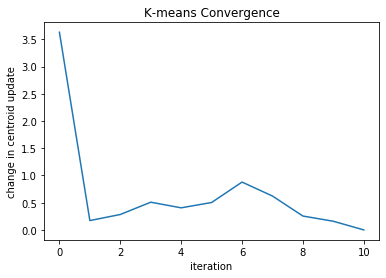

In [6]:
#plot convergence of centroids based on the delta between prior and new_centroid.
plt.plot(epsilon_list)
plt.xlabel('iteration')
plt.ylabel('change in centroid update')
plt.title('K-means Convergence');

The resulting centroid coordinates of cluster 1 is:  [2.88349711 1.35826195]
The resulting centroid coordinates of cluster 2 is:  [5.43312387 4.86267503]
The resulting centroid coordinates of cluster 3 is:  [-1.03940862 -0.6791968 ]


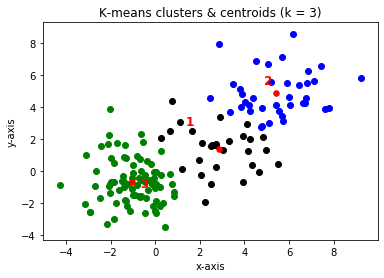

In [7]:
#final resulting centroid coordinates and plot with centroids in red.
plt.scatter(datapoints[np.where(nearest==0)][:,0], datapoints[np.where(nearest==0)][:,1],color='black')
plt.scatter(datapoints[np.where(nearest==1)][:,0], datapoints[np.where(nearest==1)][:,1],color='blue')
plt.scatter(datapoints[np.where(nearest==2)][:,0], datapoints[np.where(nearest==2)][:,1],color='green')
plt.scatter(centroids[:,0],centroids[:,1],c='r',s=30);
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('K-means clusters & centroids (k = 3)')
for i in range(k):
    plt.annotate(i+1, (centroids[i,1],centroids[i,0]), color='red', fontsize=12, fontweight='semibold')
    print('The resulting centroid coordinates of cluster '+str(i+1)+' is: ', centroids[i])

#### Expectation-Maximization Implementation

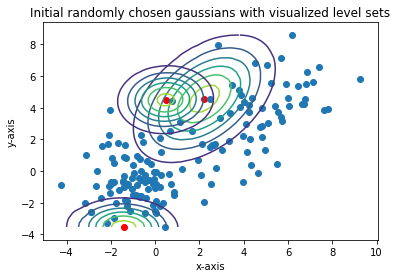

In [8]:
np.random.seed(9)
#initialization of parameters
k = 3 #number of clusters
#use centroid functions from k-means to set the initial ansatz for our random gaussian generative models
#if a different set of initial means is desired, change the random seed state.
mu = initialize_centroids(datapoints,k)
subsets = nearest_centroid(datapoints, np.asarray(mu))
sigma = np.zeros((k,2,2)) #covariance matrices at each mean
for i in range(k):
    #estimate initial covariance matrices for each gaussian model
    sigma[i] = np.asarray(np.cov(datapoints[np.where(subsets==i)][:,0],datapoints[np.where(subsets==i)][:,1]))
priors = np.ones(k)/k # initialize a uniform distribution of membership probabilities


#make a mesh to visualize level sets of the initial gmm's
x,y = np.meshgrid(np.sort(datapoints[:,0]),np.sort(datapoints[:,1]))
mesh = np.array([x.flatten(),y.flatten()]).T
#plot the initial gaussians
for m,s in zip(mu,sigma):
    gmm = mvn(mean = m,cov=s)
    plt.contour(np.sort(datapoints[:,0]),np.sort(datapoints[:,1]),gmm.pdf(mesh).reshape(150,150))
    plt.scatter(m[0],m[1],c='red')
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Initial randomly chosen gaussians with visualized level sets')
plt.scatter(datapoints[:,0],datapoints[:,1]);

In [9]:
#Run Expectation Maximation Clustering
tolerance = 0.001
mus = [mu]
while True:
    #subproblem A (Expectation step)
    
    #initialize membership probabilities as 150x3 zero matrix
    classprobs = np.zeros((len(datapoints),k))

    #get Expectations that the point was generated from initially random distributions
    for meank, covariancek, prior, j in zip(mu, sigma, priors, range(k)):
        likelihood = mvn(mean = meank,cov = covariancek)
        numerator = prior*likelihood.pdf(datapoints)
        temp = []
        for k_mu,k_cov, k_pi in zip(mu,sigma, priors):
            temp.append(k_pi*mvn(mean=k_mu,cov=k_cov).pdf(datapoints))
        denominator = np.sum(temp,axis = 0)
        #update new class probabilities
        classprobs[:,j] = numerator/denominator

    #reset the parameter lists to empy
    mu, sigma, priors = [],[],[]

    #subproblem B (Maximization step)
    for j in range(k):
        #find new means for each class
        classtotal = np.sum(classprobs[:,j],axis=0)
        clustermean = (1/classtotal)*np.sum(datapoints*classprobs[:,j].reshape(150,1),axis=0)
        mu.append(clustermean)

        #find the new covariances given the new centroid means
        covar =(1/classtotal)*np.dot((np.asarray(classprobs[:,j]).reshape(150,1)*(datapoints-clustermean)).T,(datapoints-clustermean))
        sigma.append(covar)

        #update the priors by finding new proportion of points for each centroid
        totalinsts = np.sum(classprobs)
        priors.append(classtotal/totalinsts)
    mus.append(mu)
    
    if np.linalg.norm(np.asarray(mus[-1]) - np.asarray(mus[-2]))<tolerance:
        break
    steps = [np.linalg.norm(np.asarray(mus[i]) - np.asarray(mus[i-1])) for i in range(len(mus))]

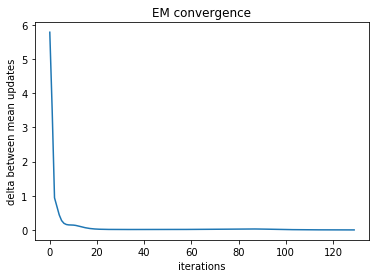

In [10]:
#Check convergence of EM algorithm
plt.plot(steps);
plt.xlabel('iterations')
plt.ylabel('delta between mean updates')
plt.title('EM convergence');

The mean of Gaussian 1 is:  [4.23971922 3.29079133]
with amplitude of:  0.04139088101121953
and Covariance Matrix: 
 [[4.09524727 2.45398838]
 [2.45398838 5.08086183]] 

The mean of Gaussian 2 is:  [-1.13390322 -1.29997857]
with amplitude of:  0.1495206525238713
and Covariance Matrix: 
 [[1.45749471 0.21739236]
 [0.21739236 0.80980072]] 

The mean of Gaussian 3 is:  [-0.90808405 -0.04092778]
with amplitude of:  0.13205888136675678
and Covariance Matrix: 
 [[ 0.82833928 -0.67469114]
 [-0.67469114  2.30300679]] 



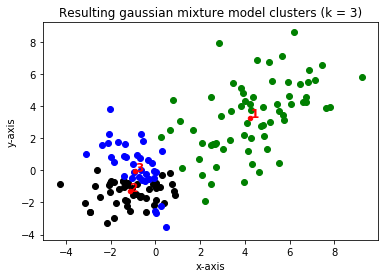

In [11]:
max_prob = np.argmax(classprobs,axis=1)
plt.scatter(datapoints[np.where(max_prob==0)][:,0], datapoints[np.where(max_prob==0)][:,1],color='green')
plt.scatter(datapoints[np.where(max_prob==1)][:,0], datapoints[np.where(max_prob==1)][:,1],color='black')
plt.scatter(datapoints[np.where(max_prob==2)][:,0], datapoints[np.where(max_prob==2)][:,1],color='blue')
plt.scatter(np.asarray(mu)[:,0],np.asarray(mu)[:,1],c='r',s=20);
plt.xlabel('x-axis')
plt.ylabel('y-axis')
for i in range(k):
    plt.annotate(i+1, (mu[i]), color='red', fontsize=12, fontweight='semibold')

plt.title('Resulting gaussian mixture model clusters (k = 3)');

#it can be shown analytically that the mode of a gaussian distribution coincides with its mean
#so to get the amplitude (maximum height), we merely have to evaluate each of our k = 3 bivariate gaussians at 
#their respective  mean coordinates and store the heights in list y.
y = [mvn.pdf(mu[i],mu[i],sigma[i]) for i in range(k)]

#report final outputs
for j in range(k):
    print('The mean of Gaussian '+str(j+1)+' is: ', mu[j])
    print('with amplitude of: ',y[j])
    print('and Covariance Matrix: \n', sigma[j],'\n')    

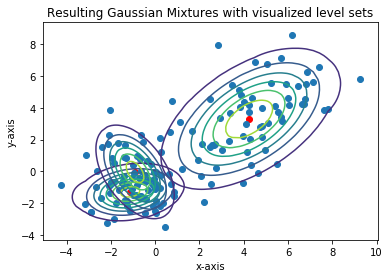

In [12]:
#Display end soft-cluster contours with visualized gaussian level sets
for m,s in zip(mu,sigma):
    gmm = mvn(mean=m,cov=s)
    plt.contour(np.sort(datapoints[:,0]),np.sort(datapoints[:,1]),gmm.pdf(mesh).reshape(150,150))
    plt.scatter(m[0],m[1],c='red')    
plt.scatter(datapoints[:,0],datapoints[:,1])
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.title('Resulting Gaussian Mixtures with visualized level sets');